In [1]:
print("strawberry")

strawberry


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        
        
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [8]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [9]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [11]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [12]:
# modified base version for p-unet

from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import get_conv_func
import torch.nn as nn
    
class HyperMapp3r_punet(HyperMapp3r):
    def __init__(self, dims=2,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }):
        super().__init__(dims, in_channels, out_channels, encoder_features, decoder_features, softmax, up_res_blocks, block_params)
        
        # reconfigure the last layer thing
        conv_func = get_conv_func(dims, transpose=False)
        self.skip_final_convs = nn.ModuleList([
            conv_func(fs, decoder_features[-1], kernel_size=1)
            for fs in decoder_features[1:-1]
        ])
        
        self.num_out_features = decoder_features[-1] * 2 + encoder_features[0]
        
    def forward(self, x):
        skip_conns = []
        out = x
        
        # print("hypermappr3")
        # print("in shape: ", x.shape)
        # print("~~ENCODER~~")
        # encoder path
        for l in range(self.down_steps):
            out = self.encoder_down_blocks[l](out)
            out = self.encoder_resuq_blocks[l](out)
            # print("encoder group out shape", out.shape)
            
            if l != self.down_steps-1:
                skip_conns.append(out)
                
        # decoder path
        # print("~~DECODER~~")
        out = self.decoder_upsample_blocks[0](out)
        secondary_skip_conns = []
        for l in range(1, self.up_steps):
            # print("decoder group in: ", out.shape)
            #print("skip conn shape: ", skip_conns[-1].shape)
            out = torch.cat([out, skip_conns.pop()], dim=1)
            #print("post cat shape: ", out.shape)
            out = self.decoder_feature_blocks[l-1](out)
            out = self.decoder_upsample_blocks[l](out)
            
            if l >= 1:
                secondary_skip_conns.append(out)
        
        #print("final cat in shape: ", out.shape)
        out = torch.cat([out, skip_conns.pop()], dim=1)
        
        
        # combine secondary skips
        sk1 = self.skip_final_convs[0](secondary_skip_conns[0])
        #print("sk1 out shape pre interpolate: ", sk1.shape)
        sk1 = self.interpolate(sk1)
        #print("sk1 out shape post interpolate: ", sk1.shape)
        sk2 = self.skip_final_convs[1](secondary_skip_conns[1])
        #print("sk2 out shape pre interpolate: ", sk2.shape)
        sk2 = torch.add(sk1, sk2)
        #print("sk2 out shape post add: ", sk2.shape)
        sk2 = self.interpolate(sk2)
        #print("sk2 out shape post interpolate: ", sk2.shape)
        
        sk2 = self.interpolate(sk2)
        out = self.interpolate(out)
        
        return torch.cat([out, sk2], dim=1)

In [13]:
#hp = HyperMapp3r_punet()

In [14]:
# z = torch.randn(1, 3, 224, 160)
# hp(z).shape

In [15]:
#summary(hp, (1, 3, 224, 160))

In [16]:
# https://github.com/stefanknegt/Probabilistic-Unet-Pytorch/blob/master/utils.py
# ben took this code from above, its the p-Unet utils.

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #nn.init.normal_(m.weight, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)
        truncated_normal_(m.bias, mean=0, std=0.001)

def init_weights_orthogonal_normal(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.orthogonal_(m.weight)
        truncated_normal_(m.bias, mean=0, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)

def l2_regularisation(m):
    l2_reg = None

    for W in m.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg

def save_mask_prediction_example(mask, pred, iter):
    plt.imshow(pred[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_prediction.png")
    plt.imshow(mask[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_mask.png")

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

class DownConvBlock(nn.Module):
    """
    A block of three convolutional layers where each layer is followed by a non-linear activation function
    Between each block we add a pooling operation.
    """
    def __init__(self, input_dim, output_dim, initializers, padding, pool=True):
        super(DownConvBlock, self).__init__()
        layers = []

        if pool:
            layers.append(nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True))

        layers.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)))
        layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

        self.layers.apply(init_weights)

    def forward(self, patch):
        return self.layers(patch)


class UpConvBlock(nn.Module):
    """
    A block consists of an upsampling layer followed by a convolutional layer to reduce the amount of channels and then a DownConvBlock
    If bilinear is set to false, we do a transposed convolution instead of upsampling
    """
    def __init__(self, input_dim, output_dim, initializers, padding, bilinear=True):
        super(UpConvBlock, self).__init__()
        self.bilinear = bilinear

        if not self.bilinear:
            self.upconv_layer = nn.ConvTranspose2d(input_dim, output_dim, kernel_size=2, stride=2)
            self.upconv_layer.apply(init_weights)

        self.conv_block = DownConvBlock(input_dim, output_dim, initializers, padding, pool=False)

    def forward(self, x, bridge):
        if self.bilinear:
            up = nn.functional.interpolate(x, mode='bilinear', scale_factor=2, align_corners=True)
        else:
            up = self.upconv_layer(x)
        
        assert up.shape[3] == bridge.shape[3]
        out = torch.cat([up, bridge], 1)
        out =  self.conv_block(out)

        return 

class Unet(nn.Module):
    """
    A UNet (https://arxiv.org/abs/1505.04597) implementation.
    input_channels: the number of channels in the image (1 for greyscale and 3 for RGB)
    num_classes: the number of classes to predict
    num_filters: list with the amount of filters per layer
    apply_last_layer: boolean to apply last layer or not (not used in Probabilistic UNet)
    padidng: Boolean, if true we pad the images with 1 so that we keep the same dimensions
    """

    def __init__(self, input_channels, num_classes, num_filters, initializers, apply_last_layer=True, padding=True):
        super(Unet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.padding = padding
        self.activation_maps = []
        self.apply_last_layer = apply_last_layer
        self.contracting_path = nn.ModuleList()

        for i in range(len(self.num_filters)):
            input = self.input_channels if i == 0 else output
            output = self.num_filters[i]

            if i == 0:
                pool = False
            else:
                pool = True

            self.contracting_path.append(DownConvBlock(input, output, initializers, padding, pool=pool))

        self.upsampling_path = nn.ModuleList()

        n = len(self.num_filters) - 2
        for i in range(n, -1, -1):
            input = output + self.num_filters[i]
            output = self.num_filters[i]
            self.upsampling_path.append(UpConvBlock(input, output, initializers, padding))

        if self.apply_last_layer:
            self.last_layer = nn.Conv2d(output, num_classes, kernel_size=1)
            #nn.init.kaiming_normal_(self.last_layer.weight, mode='fan_in',nonlinearity='relu')
            #nn.init.normal_(self.last_layer.bias)


    def forward(self, x, val=False):
        blocks = []
        for i, down in enumerate(self.contracting_path):
            x = down(x)
            if i != len(self.contracting_path)-1:
                blocks.append(x)

        for i, up in enumerate(self.upsampling_path):
            x = up(x, blocks[-i-1])

        del blocks

        #Used for saving the activations and plotting
        if val:
            self.activation_maps.append(x)
        
        if self.apply_last_layer:
            x =  self.last_layer(x)

        return 

In [18]:
#unet = Unet(3, 2, [16, 32, 64, 128, 256], {'w':'orthogonal', 'b':'normal'}, apply_last_layer=False, padding=True)



In [19]:
# standard UNet implementation as a baseline.

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

class SimpleBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, dropout_p, transpose_conv, 
                 max_pooling=False, dimensions=2):
        """
        dimensoins = 2 for 2D data, 3 for 3D data.
        """
        super().__init__()
        if dimensions == 2:
            if transpose_conv:
                self.conv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size, stride=2, output_padding=1, padding=1)
            else:
                self.conv = nn.Conv2d(in_filters, out_filters, kernel_size, stride=1, padding=1)
            self.norm = nn.BatchNorm2d(out_filters)
            self.dropout = nn.Dropout2d(dropout_p)
            self.pool = F.max_pool2d
            
        elif dimensions == 3:
            if transpose_conv:
                self.conv = nn.ConvTranspose3d(in_filters, out_filters, kernel_size, stride=2, output_padding=1, padding=1)
            else:
                self.conv = nn.Conv3d(in_filters, out_filters, kernel_size, stride=1, padding=1)
            #self.norm = nn.InstanceNorm3d(out_filters)
            self.norm = nn.BatchNorm3d(out_filters)
            self.dropout = nn.Dropout3d(dropout_p)
            self.pool = F.max_pool3d
        else:
            raise ValueError("dimensions can be only 2 or 3 (for 2D or 3D) (int)")
        
        self.do_max_pool = max_pooling
        
    
    def forward(self, x):
        x = self.conv(x)
        if self.do_max_pool:
            x = self.pool(x, 2, 2)
        x = self.norm(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        return x  
    
    
class EncoderMine(nn.Module):
    def __init__(self, channels=(3,64,128,256,512,1024), dropout_p=0.1):
        super().__init__()
        self.enc_blocks = nn.ModuleList(
            [
                SimpleBlock(channels[i], channels[i+1], kernel_size=3, dropout_p=dropout_p, transpose_conv=False) 
                for i in range(len(channels)-1)
            ]
        )
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x):
        outs = []
        for block in self.enc_blocks:
            x = block(x)
            outs.append(x)
            x = self.pool(x)
        return outs
    

class DecoderMine(nn.Module):
    def __init__(self, channels=(1024, 512, 256, 128, 64), dropout_p=0.1):
        super().__init__()
        self.channels = channels
        self.upscale_tconvs = nn.ModuleList(
            [
                SimpleBlock(channels[i], channels[i+1], kernel_size=3, dropout_p=dropout_p, transpose_conv=True)
                for i in range(len(channels) - 1)
            ]
        )
        self.dec_blocks = nn.ModuleList(
            [
                SimpleBlock(channels[i], channels[i+1], kernel_size=3, dropout_p=dropout_p, transpose_conv=False)
                for i in range(len(channels) - 1)
            ]
        )
        self.dropout_p = dropout_p
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upscale_tconvs[i](x)
            enc_out = self.crop(encoder_features[i], x)
            #enc_out = encoder_features[i]
            
            x = torch.cat([x, enc_out], dim=1)
            x = self.dec_blocks[i](x)
            
        return x
            
    def crop(self, enc_out, x):
        """
        enc_out: output of encoder at a particular layer in the stack
        x: shape of the data to be matched (the cropping nesseary due to loss of border pixels in convolution ops)
        """
        _, _, H, W = x.shape
        enc_out = torchvision.transforms.CenterCrop([H, W])(enc_out)
        return enc_out
    
class UNetMine(nn.Module):
    def __init__(self, 
                in_channels=3,
                encoder_channels=[64,128,256,512,1024],
                decoder_channels=[1024,512,256,128,64],
                dropout_p=0.1,
                num_classes=1,
                retain_dim=False,
                output_size=(572,572),
                apply_last_layer=True,
                ):
        super().__init__()
        encoder_channels = [in_channels] + encoder_channels
        self.encoder = EncoderMine(encoder_channels, dropout_p)
        self.decoder = DecoderMine(decoder_channels, dropout_p)
        self.output_head = nn.Conv2d(decoder_channels[-1], num_classes, kernel_size=1)
        self.retain_dim  = retain_dim
        self.output_size = output_size
        self.soft = nn.Softmax(dim=1)
        self.apply_last_layer = apply_last_layer
        
    def forward(self, x, ignore=None):
        encoder_features = self.encoder(x)
        # use the [::-1] to reverse the output of the encoder (think the first encoder output goes to the last decoder
        # concatenation etc.
        decoder_out = self.decoder(encoder_features[::-1][0], encoder_features[::-1][1:])
        
        if self.apply_last_layer:
            out = self.output_head(decoder_out)
        else:
            out = decoder_out
        
        # match the actual desired output image shape
        if self.retain_dim:
            out = F.interpolate(out, self.output_size)
        
        return out

In [20]:
# unet = UNetMine(3, [32,64,128,192], list(reversed([32,64,128,192])), apply_last_layer=False)
# unet = UNetMine(3, [32,64,128,256], [256,128,64,32], apply_last_layer=False)

In [21]:
# summary(unet, (1, 3, 224, 160))

In [22]:
#ben took code from: https://github.com/stefanknegt/Probabilistic-Unet-Pytorch/blob/master/probabilistic_unet.py
# and replaced their unet with hypermapp3r

#from utils import init_weights,init_weights_orthogonal_normal, l2_regularisation
import torch.nn.functional as F
from torch.distributions import Normal, Independent, kl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Encoder(nn.Module):
    """
    A convolutional neural network, consisting of len(num_filters) times a block of no_convs_per_block convolutional layers,
    after each block a pooling operation is performed. And after each convolutional layer a non-linear (ReLU) activation function is applied.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, initializers, padding=True, posterior=False):
        super(Encoder, self).__init__()
        self.contracting_path = nn.ModuleList()
        self.input_channels = input_channels
        self.num_filters = num_filters

        if posterior:
            #To accomodate for the mask that is concatenated at the channel axis, we increase the input_channels.
            self.input_channels += 1

        layers = []
        for i in range(len(self.num_filters)):
            """
            Determine input_dim and output_dim of conv layers in this block. The first layer is input x output,
            All the subsequent layers are output x output.
            """
            input_dim = self.input_channels if i == 0 else output_dim
            output_dim = num_filters[i]
            
            if i != 0:
                layers.append(nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True))
            
            layers.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=int(padding)))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_per_block-1):
                layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=int(padding)))
                layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

        self.layers.apply(init_weights)

    def forward(self, input):
        output = self.layers(input)
        return output

class AxisAlignedConvGaussian(nn.Module):
    """
    A convolutional net that parametrizes a Gaussian distribution with axis aligned covariance matrix.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, latent_dim, initializers, posterior=False):
        super(AxisAlignedConvGaussian, self).__init__()
        self.input_channels = input_channels
        self.channel_axis = 1
        self.num_filters = num_filters
        self.no_convs_per_block = no_convs_per_block
        self.latent_dim = latent_dim
        self.posterior = posterior
        if self.posterior:
            self.name = 'Posterior'
        else:
            self.name = 'Prior'
        self.encoder = Encoder(self.input_channels, self.num_filters, self.no_convs_per_block, initializers, posterior=self.posterior)
        self.conv_layer = nn.Conv2d(num_filters[-1], 2 * self.latent_dim, (1,1), stride=1)
        self.show_img = 0
        self.show_seg = 0
        self.show_concat = 0
        self.show_enc = 0
        self.sum_input = 0

        nn.init.kaiming_normal_(self.conv_layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.conv_layer.bias)

    def forward(self, input, segm=None):

        #If segmentation is not none, concatenate the mask to the channel axis of the input
        if segm is not None:
            self.show_img = input
            self.show_seg = segm
            input = torch.cat((input, segm), dim=1)
            self.show_concat = input
            self.sum_input = torch.sum(input)

        encoding = self.encoder(input)
        self.show_enc = encoding

        #We only want the mean of the resulting hxw image
        encoding = torch.mean(encoding, dim=2, keepdim=True)
        encoding = torch.mean(encoding, dim=3, keepdim=True)

        #Convert encoding to 2 x latent dim and split up for mu and log_sigma
        mu_log_sigma = self.conv_layer(encoding)

        #We squeeze the second dimension twice, since otherwise it won't work when batch size is equal to 1
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)

        mu = mu_log_sigma[:,:self.latent_dim]
        log_sigma = mu_log_sigma[:,self.latent_dim:]
        sigma = log_sigma.exp()
        sigma = torch.nn.functional.softplus(log_sigma) + 1
        
        mu = mu.clamp(-100,100)
        sigma = sigma.clamp(0, 100)

        #This is a multivariate normal with diagonal covariance matrix sigma
        #https://github.com/pytorch/pytorch/pull/11178
        # NOTE I have added the 1e-29
        dist = Independent(Normal(loc=mu, scale=sigma),1)
        return dist

class Fcomb(nn.Module):
    """
    A function composed of no_convs_fcomb times a 1x1 convolution that combines the sample taken from the latent space,
    and output of the UNet (the feature map) by concatenating them along their channel axis.
    """
    def __init__(self, num_filters, latent_dim, num_output_channels, num_classes, no_convs_fcomb, initializers, use_tile=True):
        super(Fcomb, self).__init__()
        self.num_channels = num_output_channels #output channels
        self.num_classes = num_classes
        self.channel_axis = 1
        self.spatial_axes = [2,3]
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.use_tile = use_tile
        self.no_convs_fcomb = no_convs_fcomb 
        self.name = 'Fcomb'

        if self.use_tile:
            layers = []

            #Decoder of N x a 1x1 convolution followed by a ReLU activation function except for the last layer
            layers.append(nn.Conv2d(self.num_filters[0]+self.latent_dim, self.num_filters[1], kernel_size=1))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_fcomb-2):
                layers.append(nn.Conv2d(self.num_filters[1], self.num_filters[1], kernel_size=1))
                layers.append(nn.ReLU(inplace=True))

            self.layers = nn.Sequential(*layers)

            self.last_layer = nn.Conv2d(self.num_filters[1], self.num_classes, kernel_size=1)

            if initializers['w'] == 'orthogonal':
                self.layers.apply(init_weights_orthogonal_normal)
                self.last_layer.apply(init_weights_orthogonal_normal)
            else:
                self.layers.apply(init_weights)
                self.last_layer.apply(init_weights)

    def tile(self, a, dim, n_tile):
        """
        This function is taken form PyTorch forum and mimics the behavior of tf.tile.
        Source: https://discuss.pytorch.org/t/how-to-tile-a-tensor/13853/3
        """
        init_dim = a.size(dim)
        repeat_idx = [1] * a.dim()
        repeat_idx[dim] = n_tile
        a = a.repeat(*(repeat_idx))
        order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
        return torch.index_select(a, dim, order_index)

    def forward(self, feature_map, z):
        """
        Z is batch_sizexlatent_dim and feature_map is batch_sizexno_channelsxHxW.
        So broadcast Z to batch_sizexlatent_dimxHxW. Behavior is exactly the same as tf.tile (verified)
        """
        #feature_map, sk2 = unet_out
        # print(feature_map.shape)
        # print(z.shape)
        if self.use_tile:
            z = torch.unsqueeze(z,2)
            z = self.tile(z, 2, feature_map.shape[self.spatial_axes[0]])
            z = torch.unsqueeze(z,3)
            z = self.tile(z, 3, feature_map.shape[self.spatial_axes[1]])
        # print(z.shape)
        
        # remove z from the model
        #z *= 0.

        #Concatenate the feature map (output of the UNet) and the sample 
        #taken from the latent space
        feature_map = torch.cat((feature_map, z), dim=self.channel_axis)
        # print(feature_map.shape)
        output = self.layers(feature_map)
        return self.last_layer(output)


class ProbabilisticUnet(nn.Module):
    """
    A probabilistic UNet (https://arxiv.org/abs/1806.05034) implementation.
    input_channels: the number of channels in the image (1 for greyscale and 3 for RGB)
    num_classes: the number of classes to predict
    num_filters: is a list consisint of the amount of filters layer
    latent_dim: dimension of the latent space
    no_cons_per_block: no convs per block in the (convolutional) encoder of prior and posterior
    """

    def __init__(self, input_channels=1, num_classes=1, num_filters=[32,64,128,192], latent_dim=6, no_convs_fcomb=4, beta=10.0):
        super(ProbabilisticUnet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.no_convs_per_block = 3
        self.no_convs_fcomb = no_convs_fcomb
        self.initializers = {'w':'he_normal', 'b':'normal'}
        self.beta = beta
        self.z_prior_sample = 0

        self.unet = UNetMine(3, [32,64,128,256], [256,128,64,32], apply_last_layer=False).to(device)
        self.prior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim,  self.initializers,).to(device)
        self.posterior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim, self.initializers, posterior=True).to(device)
        self.fcomb = Fcomb(self.num_filters, self.latent_dim, self.input_channels, self.num_classes, self.no_convs_fcomb, {'w':'orthogonal', 'b':'normal'}, use_tile=True).to(device)

    def forward(self, patch, segm, training=True):
        """
        Construct prior latent space for patch and run patch through UNet,
        in case training is True also construct posterior latent space
        """
        if training:
            self.posterior_latent_space = self.posterior.forward(patch, segm)
        self.prior_latent_space = self.prior.forward(patch)
        self.unet_features = self.unet.forward(patch,False)

    def sample(self, testing=False):
        """
        Sample a segmentation by reconstructing from a prior sample
        and combining this with UNet features
        """
        if testing == False:
            z_prior = self.prior_latent_space.rsample()
            self.z_prior_sample = z_prior
        else:
            #You can choose whether you mean a sample or the mean here. For the GED it is important to take a sample.
            #z_prior = self.prior_latent_space.base_dist.loc 
            z_prior = self.prior_latent_space.sample()
            self.z_prior_sample = z_prior
        return self.fcomb.forward(self.unet_features,z_prior)


    def reconstruct(self, use_posterior_mean=False, calculate_posterior=False, z_posterior=None):
        """
        Reconstruct a segmentation from a posterior sample (decoding a posterior sample) and UNet feature map
        use_posterior_mean: use posterior_mean instead of sampling z_q
        calculate_posterior: use a provided sample or sample from posterior latent space
        """
        if use_posterior_mean:
            z_posterior = self.posterior_latent_space.mean
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
        return self.fcomb.forward(self.unet_features, z_posterior)

    def kl_divergence(self, analytic=True, calculate_posterior=False, z_posterior=None):
        """
        Calculate the KL divergence between the posterior and prior KL(Q||P)
        analytic: calculate KL analytically or via sampling from the posterior
        calculate_posterior: if we use samapling to approximate KL we can sample here or supply a sample
        """
        if analytic:
            #Neeed to add this to torch source code, see: https://github.com/pytorch/pytorch/issues/13545
            kl_div = kl.kl_divergence(self.posterior_latent_space, self.prior_latent_space)
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
            log_posterior_prob = self.posterior_latent_space.log_prob(z_posterior)
            log_prior_prob = self.prior_latent_space.log_prob(z_posterior)
            kl_div = log_posterior_prob - log_prior_prob
        return kl_div

    def elbo(self, segm, analytic_kl=True, reconstruct_posterior_mean=False):
        """
        Calculate the evidence lower bound of the log-likelihood of P(Y|X)
        """
        weight = torch.Tensor([0.03/0.97, 0.97/0.03]).to(segm.device)
        #criterion = nn.BCEWithLogitsLoss(size_average = False, reduce=False, reduction=None)
        criterion = nn.CrossEntropyLoss(weight=weight, size_average = False, reduce=False, reduction=None)
        z_posterior = self.posterior_latent_space.rsample()
        
        self.kl = torch.mean(self.kl_divergence(analytic=analytic_kl, calculate_posterior=False, z_posterior=z_posterior))
        #self.kl = torch.mean(self.kl_divergence(analytic=False, calculate_posterior=True, z_posterior=z_posterior))
        # print(self.kl * self.beta)

        #Here we use the posterior sample sampled above
        self.reconstruction = self.reconstruct(use_posterior_mean=reconstruct_posterior_mean, calculate_posterior=False, z_posterior=z_posterior)
        
        reconstruction_loss = criterion(input=self.reconstruction, target=segm)
        
        # print(reconstruction_loss.sum())
        
        self.reconstruction_loss = torch.sum(reconstruction_loss)
        self.mean_reconstruction_loss = torch.mean(reconstruction_loss)

        #return -(self.reconstruction_loss + self.beta * self.kl)
        #return -self.reconstruction_loss
        return -self.reconstruction_loss, -self.beta * self.kl


In [23]:
#aag = AxisAlignedConvGaussian(input_channels=3, num_filters=[16, 32, 64, 128, 256], no_convs_per_block=2, latent_dim=256, initializers={'w':'he_normal', 'b':'normal'}, posterior=False)

In [24]:
#summary(aag, (1, 3, 224, 160))

### setup model

In [25]:
#del model_raw

In [26]:
in_channels = 3
out_channels = 1

model_raw = ProbabilisticUnet(input_channels=3, num_classes=2, num_filters=[32,64,128,192], latent_dim=2, no_convs_fcomb=4, beta=10.0)



In [27]:
model_raw(torch.randn(1, 3, 224, 160).cuda(), torch.randn(1, 1, 224, 160).cuda())

In [28]:
#summary(model_raw, input_data=[torch.randn(1, 3, 224, 160), torch.randn(1, 1, 224, 160)])

In [29]:
# z = torch.randn(1, 3, 224, 160)
# t = torch.randn(1, 2, 224, 160).argmax(dim=1).unsqueeze(1)
# with torch.no_grad():
#     model_raw.cuda()(z.cuda(), t.cuda())
#     s = model_raw.sample(True)

In [30]:
# model_raw.prior_latent_space.mean

In [31]:
# s.min(), s.max()

In [32]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F

class PUNetLitModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.is_uq_model = False
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor

        
    def forward(self, x, y, **kwargs):
        return self.model(x, y, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(True)
        
        X, y = batch
        self(X, y.unsqueeze(1), training=True)
        # dice: This term is not part of the ELBO, so we are free to sample from
        # the prior network since this is used at test-time.
        #y_hat = self.model.sample(testing=False) # or I can use reconstruct to get samples from the posterior...
        y_hat = self.model.reconstruct(use_posterior_mean=True, calculate_posterior=True)
        loss = self.loss(self.model, y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
#     def training_epoch_end(self, outs):
#         self.log('train_metric_epoch', self.logging_metric_train.compute())
        
#     def validation_epoch_end(self, outs):
#         self.log('val_metric_epoch', self.logging_metric_val.compute())
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        self(X, y.unsqueeze(1), training=True)
        y_hat = self.model.sample(testing=True)
        val_loss = self.loss(self.model, y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [33]:
#loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [34]:
def punet_loss(net, pred, target):
    #elbo = net.elbo(target)
    xent, kl = net.elbo(target)
    reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
    
    # print("elbo: ", elbo)
    
    # print("xent: " , xent)
    # print("kl: ", kl)
    # print("reg: ", reg_loss * 1e-5)
        
    dice = dice_loss(pred, target)
    
    if pred.max() > 1000 or pred.min() < -1000:
        print(pred.max(), pred.min())
        raise ValueError("to high")
    
    # print("dice: ", dice)
    
    #loss = -elbo * 1e-3 + 1e-5 * reg_loss + dice * 30
    #loss = -elbo * 1e-3 + 1e-5 * reg_loss + dice
    #loss = -elbo * 1e-3 + reg_loss * 1e-5 + dice
    #loss = dice #* 300
    #loss = -xent *1e-3 -kl +1e-5*reg_loss + dice
    loss = dice
    return loss

In [35]:
#optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer_params={"lr":1e-5}
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [36]:
model = PUNetLitModelWrapper(model_raw, punet_loss, 
                                logging_metric=DiceLossMetric,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

#model.model.load_state_dict(torch.load("no_dice_punet.ckpt"))

In [37]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
#model.model.load_state_dict(torch.load("no_dice_punet.ckpt"))

### train

In [39]:
# the trick is to train without dice first it seems, and then add a dice in later. I really need to rebalance the cross entropy antually
# (and know that the determinici model on cross entropy needs to be summed not meaned)
trainer.fit(model, train_dataloader, val_dataloader)

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/s2208943/ipdis/Trustworthai-MRI-WMH/trustworthai/models/uq_models/initial_variants/p-unet/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | ProbabilisticUnet | 3.9 M 
1 | logging_metric_train | DiceLossMetric    | 0     
2 | logging_metric_val   | DiceLossMetric    | 0     
-----------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.638    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.952
/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [33]:
# model = None
# model_raw = None
# train_dataloader = None
# val_dataloader = None
# s = None
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [48]:
#trainer.validate(model, val_dataloader)

In [49]:
torch.save(model.model.state_dict(), "no_dice_punet.ckpt")
#model.model.load_state_dict(torch.load("no_dice_punet.ckpt"))

In [ ]:
# okay so two parameters to vary now, are the latent dim size and the number of filters in the fcomb layer
# also note for the writeup how the dice can use test time samples, or not and I can do density estimation later
# also note how the architecture has been changed / where the upsamples are etc.

In [ ]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

In [ ]:
from tqdm import tqdm

In [ ]:
all_tps = []
all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        pred = model(x)
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ent = entropy_map_from_samples(samples).view([-1])
        mean = pred['logit_mean']
        mean_class = mean.argmax(dim=1).view(-1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

In [52]:
tps = torch.cat(all_tps)
tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [53]:
tps.shape, tns.shape, fps.shape, fns.shape

(torch.Size([602135]),
 torch.Size([39536161]),
 torch.Size([147914]),
 torch.Size([181571]))

In [61]:
tps.mean(), tns.mean(), fps.mean(), fns.mean()

(tensor(0.2623), tensor(0.0126), tensor(0.5449), tensor(0.4424))

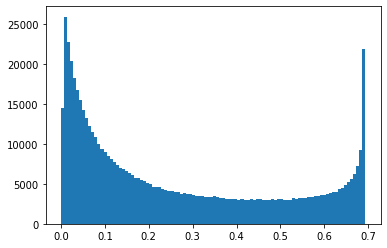

In [55]:
plt.hist(tps, bins=100);

In [57]:
#plt.hist(tns, bins=100);

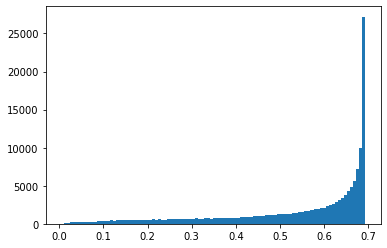

In [58]:
plt.hist(fps, bins=100);

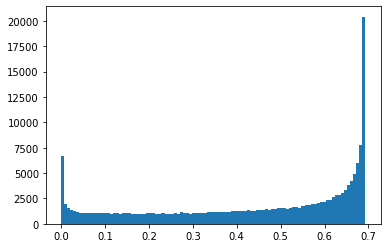

In [59]:
plt.hist(fns, bins=100);

### count the number of missing lesions per image.

In [85]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [90]:
img_t = y[23].unsqueeze(0).type(torch.float32)
labels_out = K.contrib.connected_components(img_t, num_iterations=150)
print(labels_out.shape)


torch.Size([1, 224, 160])


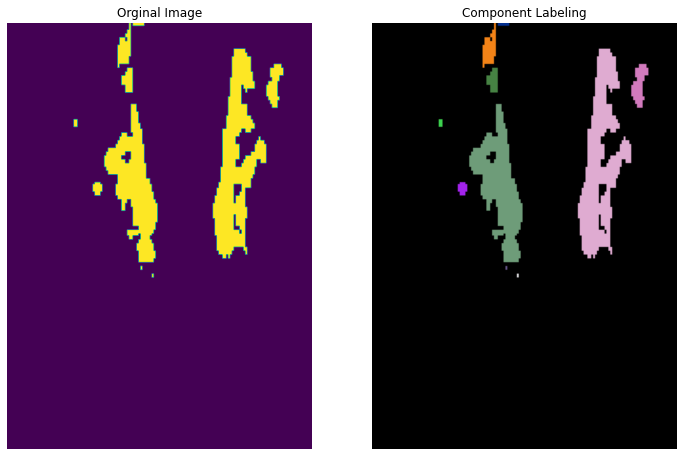

In [91]:
show_components(img_t.numpy().squeeze(), labels_out.squeeze())

In [92]:
color_ids = torch.unique(labels_out)

In [93]:
color_ids

tensor([    0.,   231.,  3738.,  5825.,  7181.,  8676., 14448., 19796., 20076.,
        20710., 21356.])

In [110]:
batch = K.contrib.connected_components(y[[20,23,26,32,5]].unsqueeze(1).type(torch.float32), num_iterations=150)

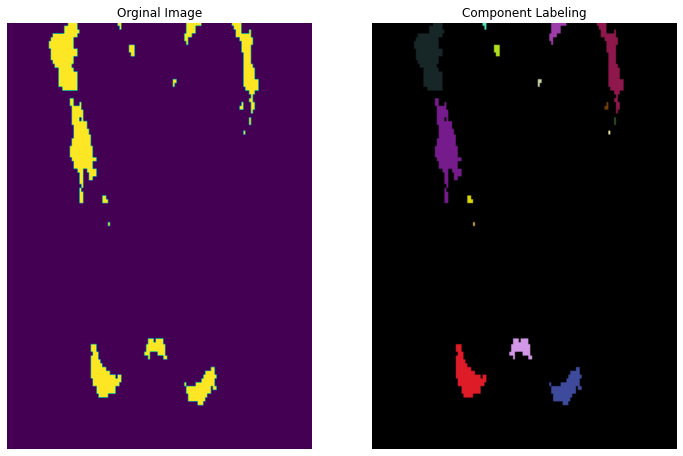

In [117]:
show_components(y[26].numpy().squeeze(), batch[2].squeeze())

In [118]:
batch[2].unique()

tensor([     0.,  72219.,  73534.,  74466.,  77047.,  77316.,  79003.,  79328.,
         80287.,  81084.,  86759.,  86772.,  88693.,  99923., 103092., 103782.])

In [123]:
ys = []
conncomp_outs = []
ents_out = []
means_out = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, leave=True, ncols=150):
        labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
        conncomp_outs.append(labels_out)
        ys.append(y)

        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        ents_out.append(entropy_map_from_samples(samples))
        means_out.append(pred['logit_mean'].cpu())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:36<00:00,  2.41s/it]


In [125]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
missing_lesion_size_mean = []
existing_lesion_size_mean = []
for batch in tqdm(range(len(ys)), position=0, leave=True, ncols=150):
    for i in range(ys[batch].shape[0]):
        conncomps = conncomp_outs[batch][i]
        ent = ents_out[batch][i]
        ent_thresh = (ent > 0.1).type(torch.long)
        mean = means_out[batch][i].argmax(dim=0).type(torch.long)
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(mean * cc) > 0:
                existing_lesion_size_mean.append(size)
            else:
                missing_lesion_size_mean.append(size)
            
            if torch.max(ent_thresh * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:27<00:00,  1.44it/s]


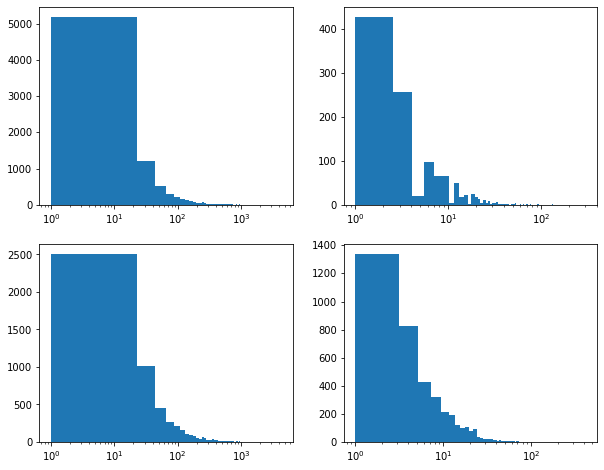

In [138]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.hist(existing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.subplot(2,2,2)
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')

plt.subplot(2,2,3)
plt.hist(existing_lesion_size_mean, bins=200);
plt.xscale('log')
plt.subplot(2,2,4)
plt.hist(missing_lesion_size_mean, bins=200);
plt.xscale('log')

In [140]:
print("means")
torch.Tensor(existing_lesion_size_ent).mean(), torch.Tensor(missing_lesion_size_ent).mean(), torch.Tensor(existing_lesion_size_mean).mean(), torch.Tensor(missing_lesion_size_mean).mean()

means


(tensor(90.5191), tensor(8.2872), tensor(132.1681), tensor(10.0472))

In [146]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [148]:
slice_dices = []
with torch.no_grad():
    for x, y in tqdm(val_dataloader, position=0, ncols=150, leave=True):
        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        
        for i in range(y.shape[0]):
            ind_dices = []
            for s in samples[:,i]:
                ind_dices.append(slice_dice(s, y[i]))
            slice_dices.append(ind_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [05:12<00:00,  7.81s/it]


In [150]:
# remove na images 
filtered_slice_dices = [x for x in slice_dices if 'n/a' not in x]

In [158]:
means = [torch.mean(torch.Tensor(x)) for x in filtered_slice_dices]

In [160]:
inds = torch.Tensor(means).sort()[1]

In [173]:
random_selection_inds = inds[torch.randint(0, len(inds), (200,)).sort()[0]]

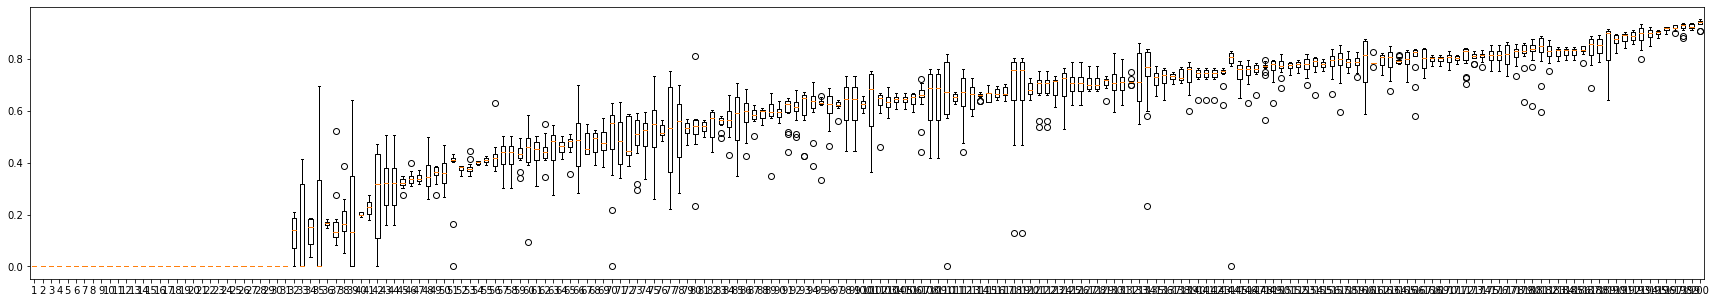

In [174]:
plt.figure(figsize=(30, 5))
plt.boxplot(torch.Tensor(filtered_slice_dices)[random_selection_inds]);

In [126]:
x, y, = next(iter(val_dataloader))

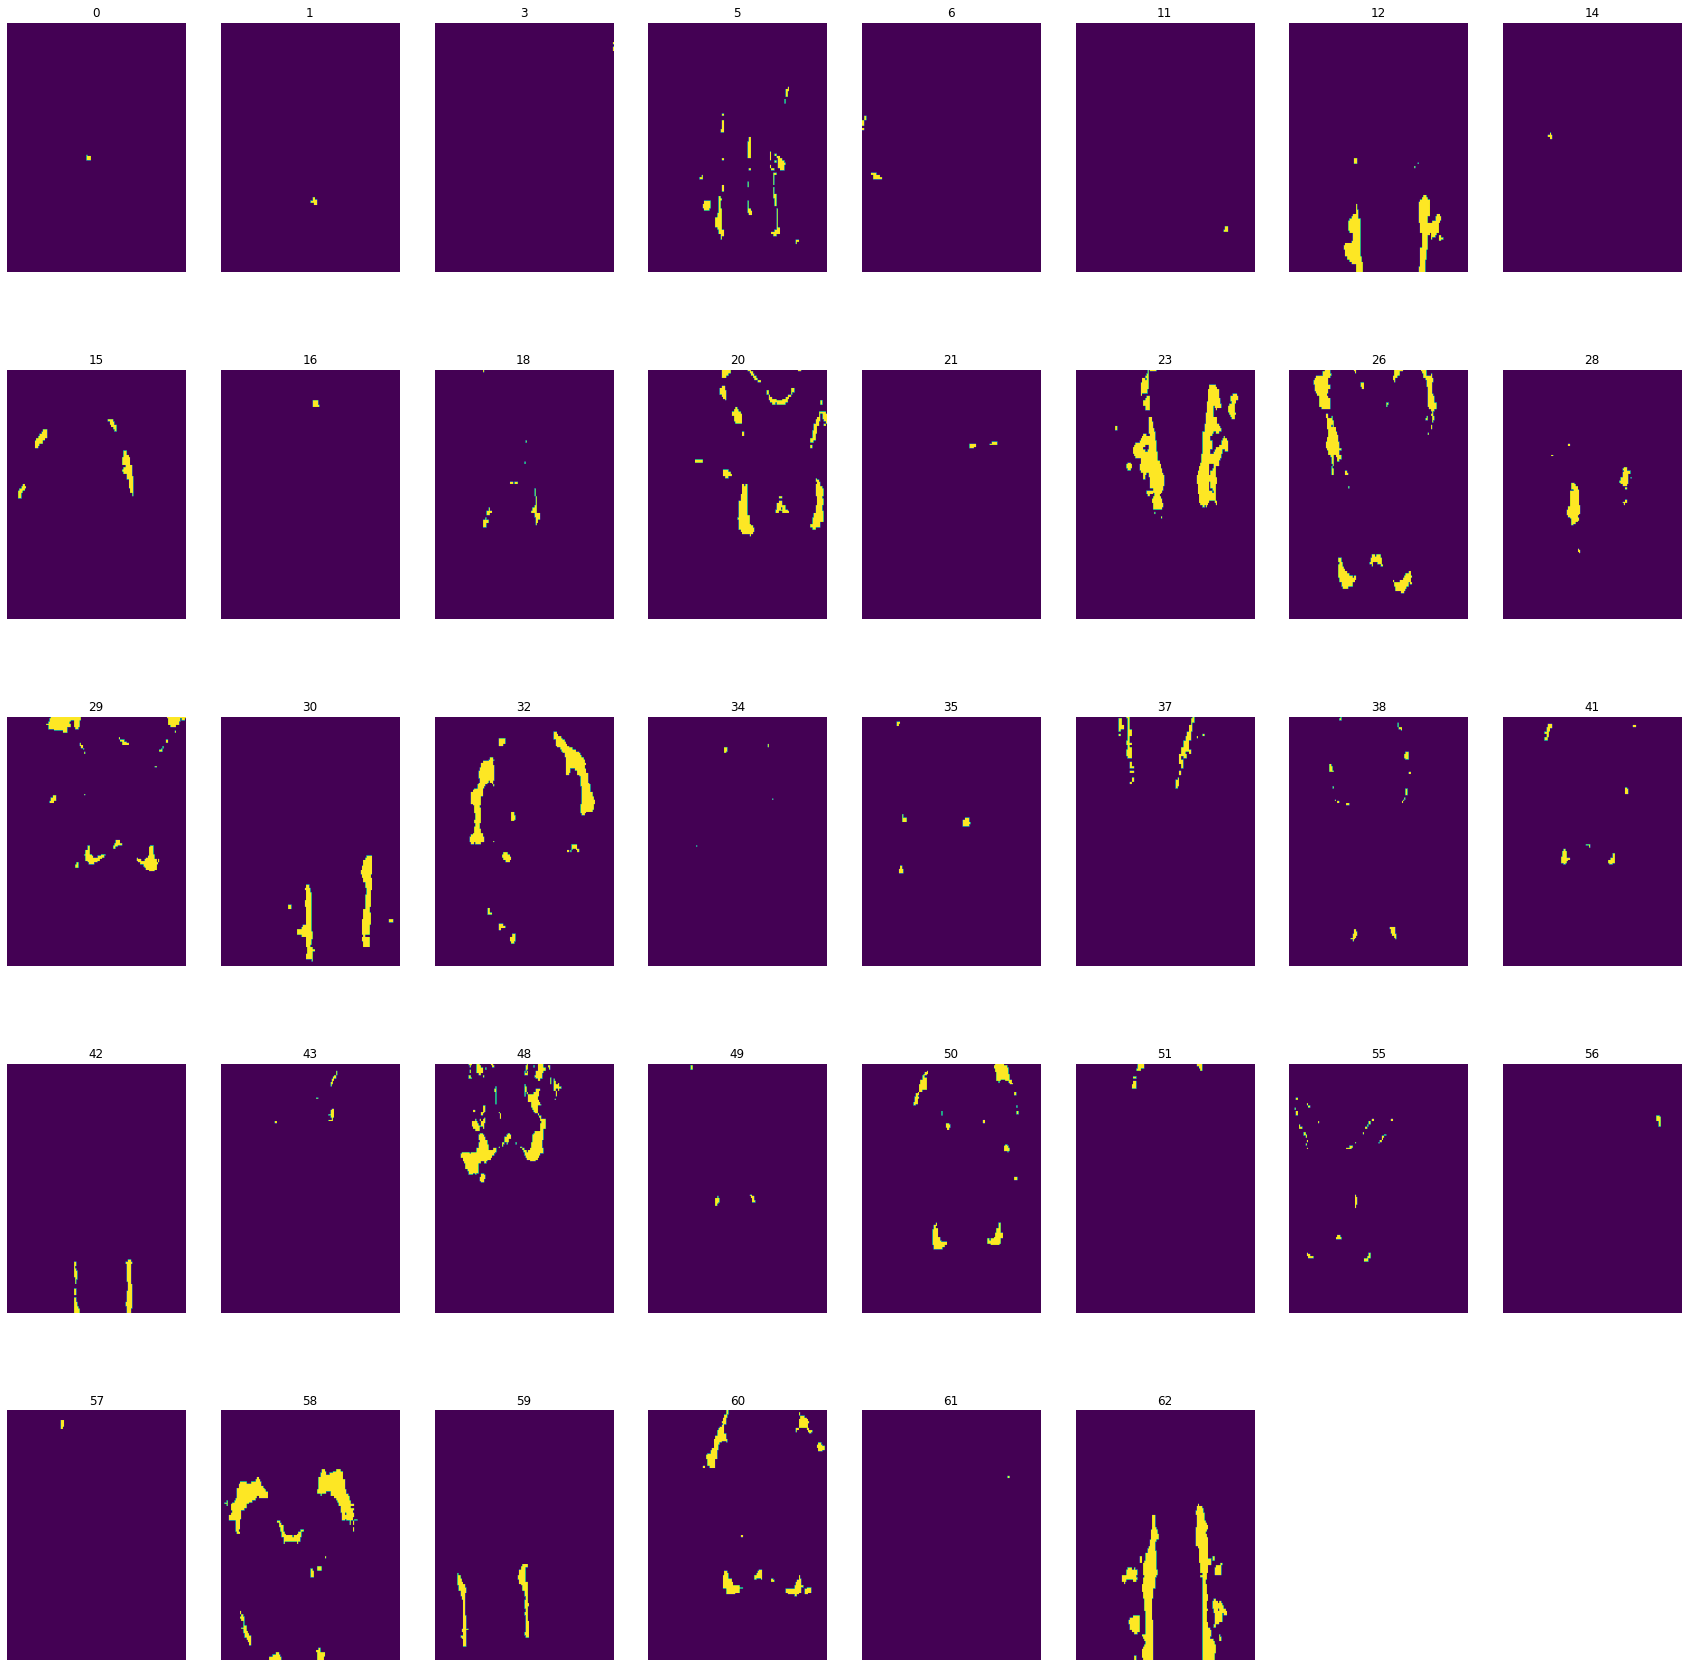

In [78]:
plt.figure(figsize=(30, 50))
count = 0
for i, img in enumerate(y):
    if torch.sum(img) > 0:
        plt.subplot(8, 8, count+1)
        plt.imshow(img); plt.axis('off');
        plt.title(i);
        count += 1
    

### look at calibrating the probability that a voxel is of class 1

In [ ]:
from tqdm import tqdm

In [61]:
results = []
targets = []
ent_maps = []
dl = val_dataloader
with torch.no_grad():
    for x, y in tqdm(dl, total=len(dl), ncols=150, position=0, leave=True):
        pred = model.cuda()(x.cuda())
        samples = fixed_re_parametrization_trick(pred['distribution'], 14).cpu()
        results.append(samples)
        targets.append(y)
        ent_maps.append(entropy_map_from_samples(samples))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.27it/s]


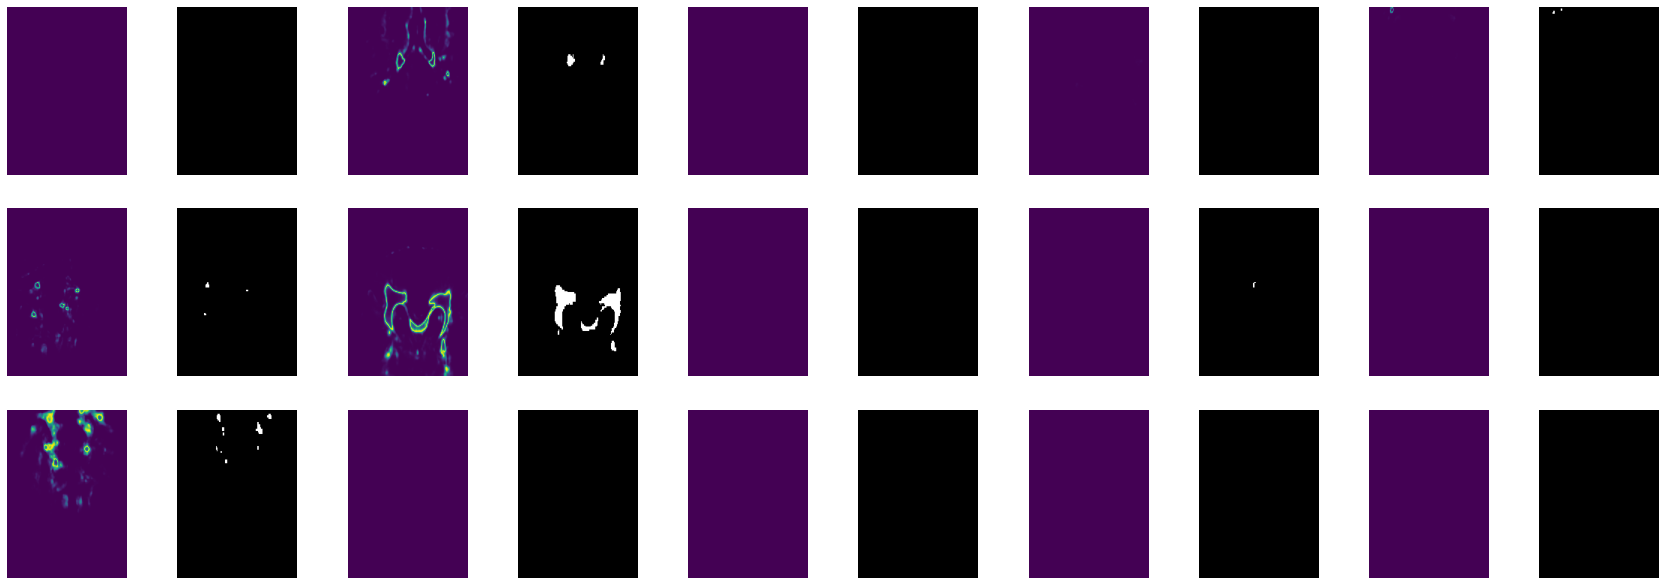

In [111]:
rand_inds_a = torch.randint(0, len(targets), (15,))
rand_inds_b = torch.randint(0, targets[0].shape[0], (15,))
plt.figure(figsize=(30, 10.5))
i = 0
for (ind_a, ind_b) in (zip(rand_inds_a, rand_inds_b)):
    plt.subplot(3, 10, i+1)
    batch = ent_maps[ind_a.item()]
    ind_b = ind_b.item()
    if batch.shape[0] <= ind_b:
        ind_b = batch.shape[0] - 1
    plt.imshow(batch[ind_b], cmap='viridis', vmin=0, vmax=0.7)
    plt.axis('off')
    
    plt.subplot(3, 10, i+2)
    plt.imshow(targets[ind_a][ind_b], cmap='gray')
    plt.axis('off')
    i += 2

In [114]:
rand_inds_a[6], rand_inds_b[6]

(tensor(18), tensor(46))

In [64]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [65]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [90]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:29<00:00,  2.24s/it]


In [91]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [92]:
bin_accuracies

[0.000643129285890609,
 0.10016226768493652,
 0.18253077566623688,
 0.2517489492893219,
 0.31688207387924194,
 0.38270920515060425,
 0.4521316587924957,
 0.5289326906204224,
 0.62313312292099,
 0.7581043839454651,
 0.9400117993354797]

In [94]:
bin_confidences

[0.00030279773636721075,
 0.08919748663902283,
 0.19547879695892334,
 0.29748061299324036,
 0.39849257469177246,
 0.499298095703125,
 0.5999094247817993,
 0.7006909847259521,
 0.8020641803741455,
 0.9065460562705994,
 0.9876070618629456]

In [ ]:
"""
looking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing
and when optimizing calibration I should be optimizing this.
"""

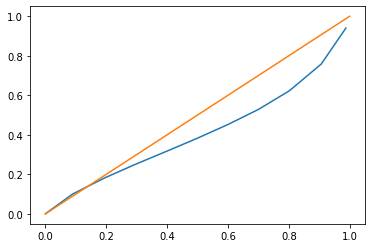

In [97]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);

In [95]:
exd = batch_t.expand(p1s.shape)

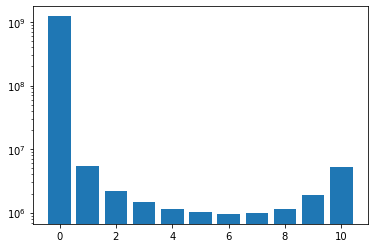

In [96]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

In [99]:
# now assess true calibration
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # split into bins
    bin_ids = place_in_bin(confidences)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        
        # number of predictions = to class 1
        c1_acc = (batch_t.expand(pred_classes.shape)[is_in_bin] == pred_classes[is_in_bin]).sum() / num_elem
        
        # average confidence of values in that bin
        c1_conf = confidences[is_in_bin].mean()
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)
    # 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:37<00:00,  6.93s/it]


In [100]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

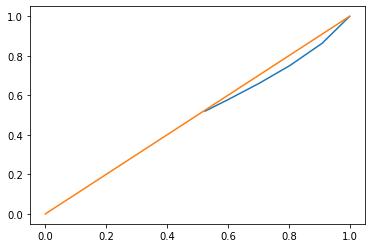

In [101]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1])

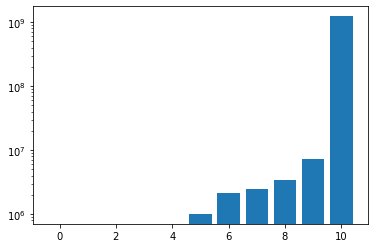

In [102]:
plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
plt.yscale("log")

### Compute the PavPU metrics cause I'm not convinced my previous code in original ssn notebook was incorrect.

In [104]:
# I am going to do it per patch, but take the average accuracy per patch (perhaps I should qc average dice as well, best dice, worst dice.
uncetainty_thresholds = torch.arange(0, 0.7, 0.01)
accuracy_threshold = 0.9
window = 8
stride = 8
n_acs = [[] for i in range(len(uncetainty_thresholds))]
n_aus = [[] for i in range(len(uncetainty_thresholds))]
n_ics = [[] for i in range(len(uncetainty_thresholds))]
n_ius = [[] for i in range(len(uncetainty_thresholds))]

for batch_idx in tqdm(range(len(targets)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = targets[batch_idx]
    batch_samples = results[batch_idx]
    ent = ent_maps[batch_idx]
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # get average accuracy of each sample
    # or I could treat each patch of each sample as a separate thing but that is not what I am doing here.
    avg_accuracy = ((batch_t.expand(pred_classes.shape) == pred_classes) * 1.).mean(dim=0)
    
    # unroll predictions and targets and entropy
    t_unrolled = batch_t.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    accuracy_unrolled = avg_accuracy.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    ent_unrolled = ent.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    
    accurate_patches = accuracy_unrolled > 0.9
    
    # for each uncertainty threshold, compute the 4 numbers
    for i, uncert_t in enumerate(uncetainty_thresholds):
        uncertain_patches = ent_unrolled > uncert_t
        
        n_acs[i].append(torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches)))
        n_aus[i].append(torch.sum(torch.logical_and(accurate_patches, uncertain_patches)))
        n_ics[i].append(torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches)))
        n_ius[i].append(torch.sum(torch.logical_and(~accurate_patches, uncertain_patches)))
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [03:27<00:00,  5.20s/it]


In [105]:
n_acs_t = [torch.Tensor(n_acs[i]).sum() for i in range(len(uncetainty_thresholds))]
n_aus_t = [torch.Tensor(n_aus[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ics_t = [torch.Tensor(n_ics[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ius_t = [torch.Tensor(n_ius[i]).sum() for i in range(len(uncetainty_thresholds))]

In [106]:
p_acs = [n_acs_t[i] / (n_acs_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
p_aus = [n_ius_t[i] / (n_ius_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
pavpu = [(n_acs_t[i] + n_ius_t[i]) / (n_ius_t[i] + n_ics_t[i] + n_aus_t[i] + n_acs_t[i]) for i in range(len(uncetainty_thresholds))]

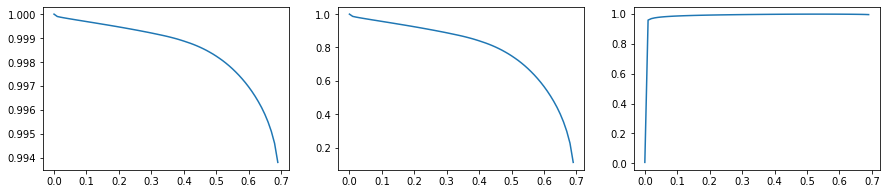

In [107]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(uncetainty_thresholds, p_acs)
plt.subplot(1,3,2)
plt.plot(uncetainty_thresholds, p_aus)
plt.subplot(1,3,3)
plt.plot(uncetainty_thresholds, pavpu)

### Trying again to look at per slice dice and quality control in 2d

### Look at baselines for interactive learning now I have a better idea of how to do it

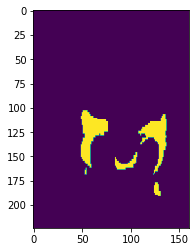

In [115]:
# how to find largest areas which are
plt.imshow(targets[18][46])

In [119]:
summer = torch.nn.Conv2d(1, 1, 3, padding='same', bias=False)
summer.weight.data = torch.ones(summer.weight.data.shape)

In [136]:
img = targets[18][46].unsqueeze(0).unsqueeze(0).type(torch.float32)

In [213]:
s1 = results[18][0][46]
s2 = results[18][1][46]

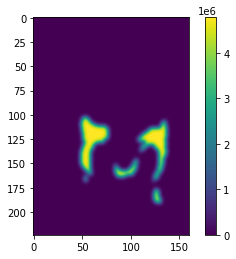

In [176]:
n = 7
with torch.no_grad():
    out = img
    for i in range(n):
        out = summer(out)
plt.imshow(out.squeeze())
plt.colorbar()

In [177]:
# efficient global maxima is to compute max pool 2d and see which pixels stay the same
mp = torch.nn.functional.max_pool2d(out, kernel_size=5,stride=1, padding=2)

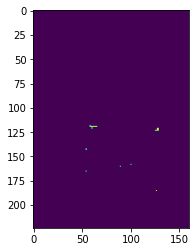

In [178]:
plt.imshow(torch.logical_and(out == mp, out > 1e-1).squeeze())

In [ ]:
# building the consistency loss that says points near a label should be similar
# so I should do the cross entropy loss multiplied by the distance between annotated points (and I should probably weight this in some way), along with a consistency loss

# building the consistency losses
# should be distance between annotations informing incorrectness plus closeness (1-distance?) to annotations informing correctness.

In [196]:
x = torch.arange(0, 224, 1)
y = torch.arange(0, 160, 1)
xs, ys = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack([xs, ys], dim=0)

points = torch.Tensor([[50,75], [200,100], [100,149]])
grid_points = grid.permute(1,2,0)

def get_grid():
    x = torch.arange(0, 224, 1)
    y = torch.arange(0, 160, 1)
    xs, ys = torch.meshgrid(x, y, indexing='ij')
    grid = torch.stack([xs, ys], dim=0)
    return grid

def dist(values, point):
    return torch.sqrt((values[0] - point[0]) ** 2. + (values[1] - point[1]) ** 2.)

def dists_all(values, points):
    return torch.stack([dist(grid, p) for p in points])

In [197]:
dists = torch.stack([dist(grid, p) for p in points])

In [249]:
min_dist

tensor([[ 90.1388,  89.3085,  88.4816,  ...,  96.0417,  96.8969,  97.7548],
        [ 89.5879,  88.7525,  87.9204,  ...,  95.5249,  96.3846,  97.2471],
        [ 89.0449,  88.2043,  87.3670,  ...,  95.0158,  95.8801,  96.7471],
        ...,
        [102.1812, 101.2028, 100.2247,  ...,  60.7454,  61.6847,  62.6259],
        [102.3914, 101.4150, 100.4390,  ...,  61.0983,  62.0322,  62.9682],
        [102.6109, 101.6366, 100.6628,  ...,  61.4654,  62.3939,  63.3246]])

In [265]:
min_dist = dists.min(dim=0)[0]

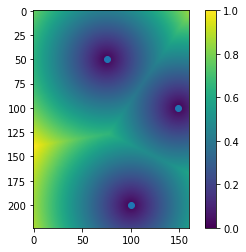

In [270]:
plt.imshow((min_dist/torch.max(min_dist))**1)
plt.colorbar()
plt.scatter(points[:,1], points[:,0]);

In [ ]:
# so the l1 loss should be multiplied by the max of (distance from incorrect points in the annotation, closeness to corrent points in the annotatoin)
# along with the cross entropy loss that is multiplied by the closeness to all annotated points.

# as for the baselines
# i can pick two baselines, one where incorrect points are picked randomly (along with a few random correct points picked)
# or, I can pick points either that are most correct or most incorrect, where I define 'most' by doing the convolution sum n times and picking the pixels
# that are the biggest (find the global maxima) using the policy that I outlined above. I can compare these baselines to using the uncertainty to guide which
# points should be picked by the user.

# the uncertainty model uses maximum uncertainty to suggest to the user the best locations to be annotated. I should add some annotation noise by moving the point slightly.

In [ ]:
def proximity_l1(y_update, y_orig, incorrect_annotations, correct_annotations, lambda_inc, lambda_corr):
    l1_loss = torch.nn.functional.l1_loss(y_update, y_orig, reduction='none')
    grid = get_grid()
    incorrect_dists = dists_all(grid, incorrect_annotations).min(dim=0)[0]
    correct_dists = dists_all(grid, correct_annotations).min(dim=0)[0]
    
    # get max of closeness to correct annotation factor * distance from incorrect annotation factor.
    rectified_l1 = l1_loss * torch.maximum((incorrect_dists/torch.max(incorrect_dists)) ** lamba_inc, (1.- (correct_dists/torch.max(correct_dists))**lambda_corr))
    
    return rectified_l1.mean()


def proximity_cross_entropy(y_pred, y_true, class_weight, annotations, lambda_proximity):
    xent_loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight=class_weight, reduction='none')
    
    point_proximity = dists_all(grid, annotations).min(dim=0)[0]
    
    rectified_xent = xent_loss * ((point_proximity/point_proximity.max()) ** lambda_proximity)
    
    return rectified_xent.mean()

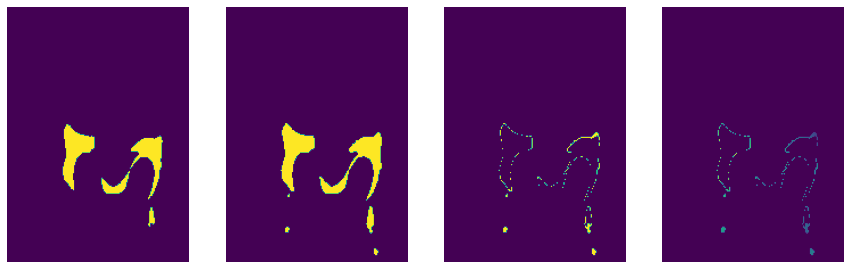

In [260]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(s2.argmax(dim=0)); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(s1.argmax(dim=0));plt.axis('off');
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.l1_loss(s1.argmax(dim=0), s2.argmax(dim=0), reduction='none')); plt.axis('off');
plt.subplot(1,4,4)
plt.imshow(torch.nn.functional.l1_loss(s1.argmax(dim=0), s2.argmax(dim=0), reduction='none') * ((min_dist/torch.max(min_dist))**1).type(torch.float32)); plt.axis('off');

### Look at quality controlling the uncertainty in 3D

### Plots

In [79]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator) / (denominator + 1e-8)) / (s0-ignores) # s0

In [80]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [81]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [82]:
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2633)

In [83]:
mc_loss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(194.5317)

In [84]:
samples = fixed_re_parametrization_trick(y_hat['distribution'], 20)
probs = torch.nn.functional.softmax(samples, dim=2)
pic = torch.mean(probs, dim=0)
ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1).cpu()

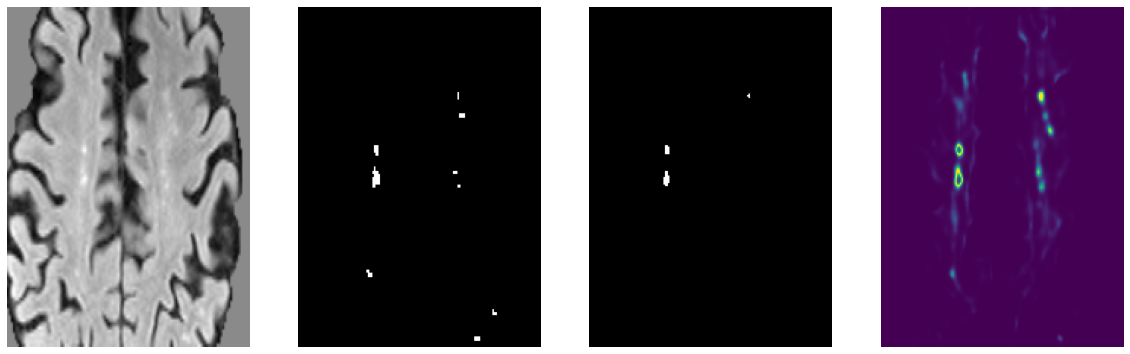

In [85]:
ind = 50
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

In [102]:
with torch.no_grad():
    steps = 5
    device = wrapped_interact_model.device
    new_result, update_maps, means = wrapped_interact_model(x1.to(device), y1.to(device), steps-1, diagnostic=True)

In [103]:
samples1 = fixed_re_parametrization_trick(new_result['distribution'], 20)
probs1 = torch.nn.functional.softmax(samples1, dim=2)
pic1 = torch.mean(probs1, dim=0)
ent_map1 = torch.sum(-pic1 * torch.log(pic1+1e-30), dim=1).cpu()

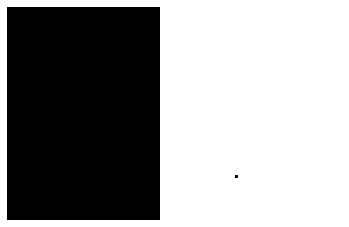

In [104]:
plt.subplot(1,2,1)
plt.imshow(update_maps[0][ind][0], cmap='gray'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(update_maps[0][ind][1], cmap='binary'); plt.axis('off');

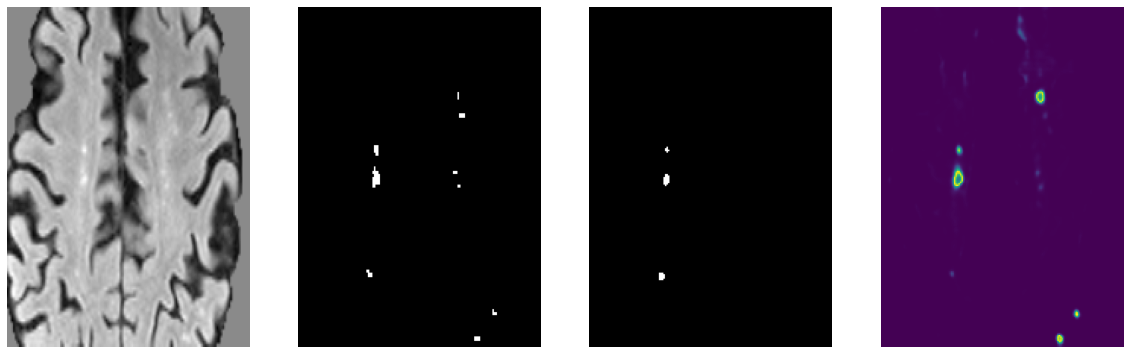

In [114]:
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(means[0].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map1[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

tensor(0.5152)


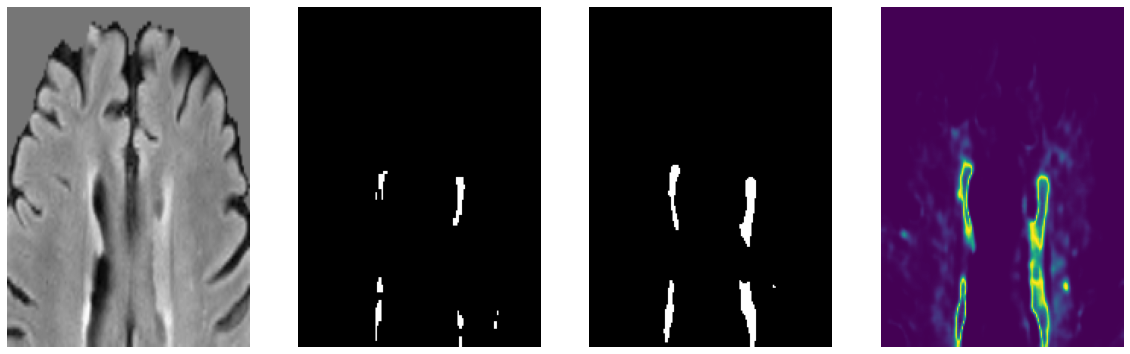

In [68]:
ind = 16#16 #27
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

### Building the interactive model


### TODO
- need to filter out slices where the prediction exactly matches the target I guess.
- note that the distribution of true positive and false positive is not balanced at all so may need to do some clever sampling here.
- reweight new predictions in the training data. Need a mechanism for doing this, say once an epoch (im not sure it should be reweighted though actually, because otherwise it will just converge to the new stuff later on, so randomly sample from the whole lot actually is my view. Nice.
- extra augmentations impelment to prevent overfitting on the small validation data
- custom fitter code to run all of this.

In [78]:
y_pred = torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)

In [328]:
ind = 17
y_pred_slice = y_pred[ind]
y1_slice = y1[ind]
diff = y_pred_slice != y1_slice
where = torch.where(diff)

update_point = torch.randint(0, len(where[0]), (1,)).item()

In [398]:
umap = generate_update_filter(y_pred_slice, y1_slice, 3)

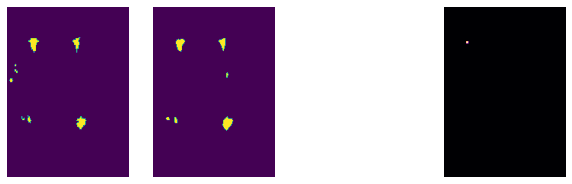

In [399]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(y1[ind]); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y_pred[ind]);plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(umap[0], cmap='binary'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(umap[1], cmap='magma'); plt.axis('off');